USAR XTREMEBOOST (KMEANS, DBSCAN, OUTROS) PARA AGRUPAR OS REGISTROS
COM AS TABELAS NO BIGQUERY, CONSUMIR AS COISAS DE LÁ
ALEM DO XTREMBOOST LOCAL, RODAR O ML_KMEANS DO SPARK E O ML_KMEANS DO BIGQUERY

no README
- explicar q sao 2 notebooks
- o primeiro notebook utilizou as bases fisicas, sem se conectar na internet
- o segundo notebook foi utilizado para realizar as analises e criar os graficos, machine learning para o app streamlit
- as bases de dados não serão disponibilizadas em conjunto com o notebook, mas há um link para download delas no app streamlit

# 1) Instalando dependências externas

In [1]:
!pip install pyspark
!pip install google-cloud-bigquery
!pip install pywaffle

In [2]:
from google.colab import auth
from google.colab import data_table
from google.cloud import bigquery
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pandas as pd
import numpy as np
import plotly.graph_objs as go
import matplotlib.pyplot as plt
from pywaffle import Waffle

# 2) Google Big Query

In [3]:
# estabelece a conexão com GCP Big Query
project = 'silver-axon-412605'
schema = 'postech_fiap_data_science_danilo'
location = 'US'
client = bigquery.Client(project = project, location = location)
data_table.enable_dataframe_formatter()

auth.authenticate_user()

In [4]:
# consulta todos os registros das tabelas de processados e auxiliares no Big Query e cria seus respectivos dataframes do pandas
query_job = client.query(f'''
  SELECT *
  FROM {schema}.pnad_covid_2020_processado
''')
df_pnad = query_job.result().to_dataframe()

In [5]:
query_job = client.query(f'''
  SELECT *
  FROM {schema}.pnad_covid_2020_aux_capital
''')
df_capital = query_job.result().to_dataframe()

In [6]:
query_job = client.query(f'''
  SELECT *
  FROM {schema}.pnad_covid_2020_aux_escolaridade
''')
df_escolaridade = query_job.result().to_dataframe()

In [7]:
query_job = client.query(f'''
  SELECT *
  FROM {schema}.pnad_covid_2020_aux_medida_restricao
''')
df_medida_restricao = query_job.result().to_dataframe()

In [8]:
query_job = client.query(f'''
  SELECT *
  FROM {schema}.pnad_covid_2020_aux_raca
''')
df_raca = query_job.result().to_dataframe()

In [9]:
query_job = client.query(f'''
  SELECT *
  FROM {schema}.pnad_covid_2020_aux_regiao_metropolitana
''')
df_regiao_metropolitana = query_job.result().to_dataframe()

In [10]:
query_job = client.query(f'''
  SELECT *
  FROM {schema}.pnad_covid_2020_aux_resultado
''')
df_resultado_exame = query_job.result().to_dataframe()

In [11]:
query_job = client.query(f'''
  SELECT *
  FROM {schema}.pnad_covid_2020_aux_resposta
''')
df_resposta = query_job.result().to_dataframe()

In [12]:
query_job = client.query(f'''
  SELECT *
  FROM {schema}.pnad_covid_2020_aux_sexo
''')
df_sexo = query_job.result().to_dataframe()

In [13]:
query_job = client.query(f'''
  SELECT *
  FROM {schema}.pnad_covid_2020_aux_situacao_domicilio
''')
df_situacao_domicilio = query_job.result().to_dataframe()

In [14]:
query_job = client.query(f'''
  SELECT *
  FROM {schema}.pnad_covid_2020_aux_tipo_area
''')
df_tipo_area = query_job.result().to_dataframe()

In [15]:
query_job = client.query(f'''
  SELECT *
  FROM {schema}.pnad_covid_2020_aux_uf
''')
df_uf = query_job.result().to_dataframe()

In [16]:
df_pnad.shape

(1149197, 31)

In [17]:
df_pnad.head()

,uf,capital,regiao_metropolitana,semana_mes_v1012,mes_v1013,situacao_domicilio_v1022,tipo_area_v1023,morador_idade_a002,morador_sexo_a003,morador_raca_a004,...,sintoma_perda_olfato_b00111,sintoma_dor_muscular_b00112,sintoma_diarreia_b00113,compareceu_estabelecimento_saude_b002,sedado_entubado_b006,tem_plano_saude_b007,resultado_exame_b009b,medida_restricao_contato_b011,trabalhou_remoto_c013,recebeu_auxilio_emergencial_d0051
0,11,11,<NA>,2,11,1,1,7,1,4,...,2,2,2,<NA>,<NA>,1,<NA>,3,<NA>,2
1,11,11,<NA>,2,11,1,1,7,1,2,...,2,2,2,<NA>,<NA>,2,<NA>,3,<NA>,1
2,11,11,<NA>,3,11,1,1,13,2,4,...,2,2,2,<NA>,<NA>,2,<NA>,3,<NA>,1
3,11,11,<NA>,4,11,1,1,5,1,4,...,2,2,2,<NA>,<NA>,1,<NA>,3,<NA>,2
4,11,11,<NA>,1,11,1,1,2,1,4,...,2,2,2,<NA>,<NA>,2,<NA>,2,<NA>,1


In [18]:
df_pnad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149197 entries, 0 to 1149196
Data columns (total 31 columns):
 #   Column                                 Non-Null Count    Dtype
---  ------                                 --------------    -----
 0   uf                                     1149197 non-null  Int64
 1   capital                                270626 non-null   Int64
 2   regiao_metropolitana                   363972 non-null   Int64
 3   semana_mes_v1012                       1149197 non-null  Int64
 4   mes_v1013                              1149197 non-null  Int64
 5   situacao_domicilio_v1022               1149197 non-null  Int64
 6   tipo_area_v1023                        1149197 non-null  Int64
 7   morador_idade_a002                     1149197 non-null  Int64
 8   morador_sexo_a003                      1149197 non-null  Int64
 9   morador_raca_a004                      1149197 non-null  Int64
 10  morador_escolaridade_a005              1149197 non-null  Int64
 11

In [19]:
# cria um schema do Spark para conversão do dataframe do pandas num dataframe do Spark
schema = StructType([StructField(x, IntegerType(), True) for x in df_pnad.columns])

In [20]:
# cria a sessão no Spark
spark = SparkSession.builder.master("local[*]").getOrCreate()
# converte o dataframe do pandas com o schema previamente criado num dataframe do Spark
df_pnad_spark = spark.createDataFrame(df_pnad, schema=schema, verifySchema=False)
# cria uma view da PNAD dentro do contexto do Spark
df_pnad_spark.createOrReplaceTempView('pnad')

In [21]:
# verificando a quantidade de registros no dataframe Spark
print(df_pnad_spark.count())

1149197


In [22]:
# verificando a quantidade de registros na view (deve bater com as outras contagens)
spark.sql('''
  SELECT COUNT(1) as total
  FROM pnad
''').show()

+-------+
|  total|
+-------+
|1149197|
+-------+



In [23]:
df_pnad_spark.printSchema()

root
 |-- uf: integer (nullable = true)
 |-- capital: integer (nullable = true)
 |-- regiao_metropolitana: integer (nullable = true)
 |-- semana_mes_v1012: integer (nullable = true)
 |-- mes_v1013: integer (nullable = true)
 |-- situacao_domicilio_v1022: integer (nullable = true)
 |-- tipo_area_v1023: integer (nullable = true)
 |-- morador_idade_a002: integer (nullable = true)
 |-- morador_sexo_a003: integer (nullable = true)
 |-- morador_raca_a004: integer (nullable = true)
 |-- morador_escolaridade_a005: integer (nullable = true)
 |-- sintoma_febre_b0011: integer (nullable = true)
 |-- sintoma_tosse_b0012: integer (nullable = true)
 |-- sintoma_dor_garganta_b0013: integer (nullable = true)
 |-- sintoma_dificuldade_respiracao_b0014: integer (nullable = true)
 |-- sintoma_dor_cabeca_b0015: integer (nullable = true)
 |-- sintoma_dor_peito_b0016: integer (nullable = true)
 |-- sintoma_nausea_b0017: integer (nullable = true)
 |-- sintoma_nariz_entupido_b0018: integer (nullable = true)
 |-

In [24]:
df_pnad_spark.show(5)

+---+-------+--------------------+----------------+---------+------------------------+---------------+------------------+-----------------+-----------------+-------------------------+-------------------+-------------------+--------------------------+------------------------------------+------------------------+-----------------------+--------------------+----------------------------+--------------------+------------------------+---------------------------+---------------------------+-----------------------+-------------------------------------+--------------------+--------------------+---------------------+-----------------------------+---------------------+---------------------------------+
| uf|capital|regiao_metropolitana|semana_mes_v1012|mes_v1013|situacao_domicilio_v1022|tipo_area_v1023|morador_idade_a002|morador_sexo_a003|morador_raca_a004|morador_escolaridade_a005|sintoma_febre_b0011|sintoma_tosse_b0012|sintoma_dor_garganta_b0013|sintoma_dificuldade_respiracao_b0014|sintoma_dor_

# 3) Segmentando o público

## 3.1) Sexo

In [25]:
df_pnad_sexo = df_pnad['morador_sexo_a003'].value_counts()

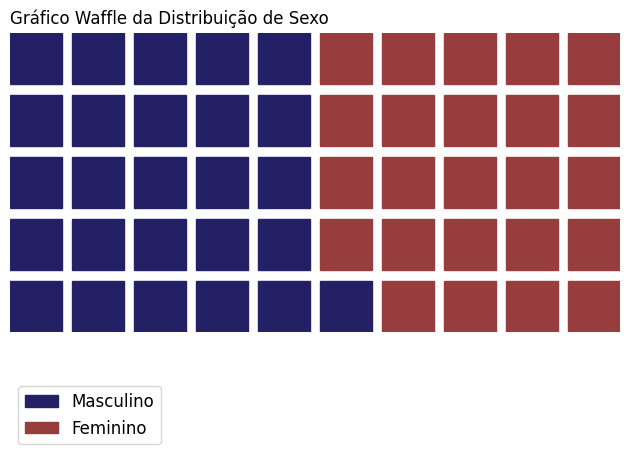

In [26]:
fig = go.Figure()
fig.add_trace(go.Pie(labels=df_pnad_sexo.index, values=df_pnad_sexo.values, hole=.65))
fig.update_layout(title='Segmentação por sexo')
fig.show()

fig = plt.figure(
    FigureClass=Waffle,
    rows=5,
    columns=10,
    values=df_pnad_sexo,
    colors=["#232066", "#983D3D"],
    title={'label': 'Gráfico Waffle da Distribuição de Sexo', 'loc': 'left'},
    labels=["Masculino", "Feminino"],
    legend={'loc': 'lower left', 'bbox_to_anchor': (0, -0.4), 'fontsize': 12},
    plot_anchor='C'
)
plt.show()

## 3.2) Estado

In [27]:
df_pnad_uf = df_pnad['uf'].value_counts()

In [28]:
fig = go.Figure()
fig.add_trace(go.Bar(x=df_pnad_uf.index, y=df_pnad_uf.values))
fig.update_layout(title='Segmentação por UF')
fig.show()

## 3.3) Região metropolitana

In [29]:
df_pnad_regiao_metropolitana = df_pnad['regiao_metropolitana'].value_counts()

In [30]:
fig = go.Figure()
fig.add_trace(go.Bar(x=df_pnad_regiao_metropolitana.index, y=df_pnad_regiao_metropolitana.values))
fig.update_layout(title='Segmentação por RM')
fig.show()

## 3.4) Escolaridade

In [31]:
df_pnad_escolaridade = df_pnad['morador_escolaridade_a005'].value_counts()

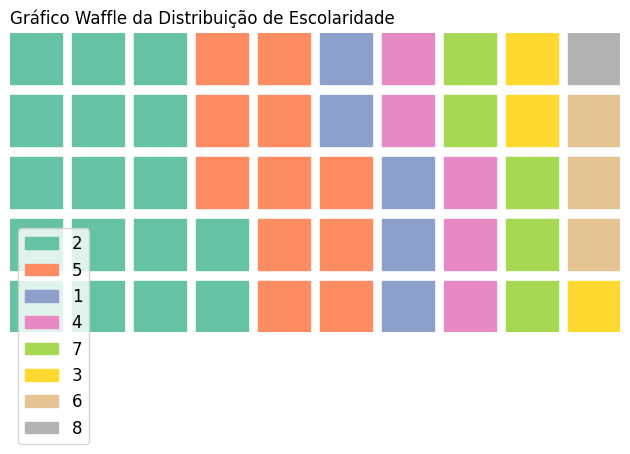

In [32]:
fig = go.Figure()
fig.add_trace(go.Pie(labels=df_pnad_escolaridade.index, values=df_pnad_escolaridade.values, hole=.65))
fig.update_layout(title='Segmentação por escolaridade')
fig.show()

fig = plt.figure(
    FigureClass=Waffle,
    rows=5,
    columns=10,
    values=df_pnad_escolaridade,
    # colors=["#232066", "#983D3D"],
    title={'label': 'Gráfico Waffle da Distribuição de Escolaridade', 'loc': 'left'},
    labels=df_pnad_escolaridade.index.array,
    legend={'loc': 'lower left', 'bbox_to_anchor': (0, -0.4), 'fontsize': 12},
    plot_anchor='C'
)
plt.show()

## 3.5) Idade

In [33]:
df_pnad_idade = df_pnad['morador_idade_a002'].value_counts(bins=[0, 18, 35, 50, 65, 80, 120], sort=False)

In [34]:
faixas_etarias = df_pnad_idade.index.astype(str).tolist()
populacao = df_pnad_idade.values

# Criar o gráfico de barras horizontais
fig = go.Figure(go.Bar(
            x=populacao,
            y=faixas_etarias,
            orientation='h'))

# Atualizar o layout
fig.update_layout(title='Distribuição por Faixa Etária',
                  xaxis_title='Número de Indivíduos',
                  yaxis_title='Faixas Etárias')

# Mostrar o gráfico
fig.show()

## 3.6) Tem plano de sáude?

In [35]:
df_pnad_plano_saude = df_pnad['tem_plano_saude_b007'].value_counts()

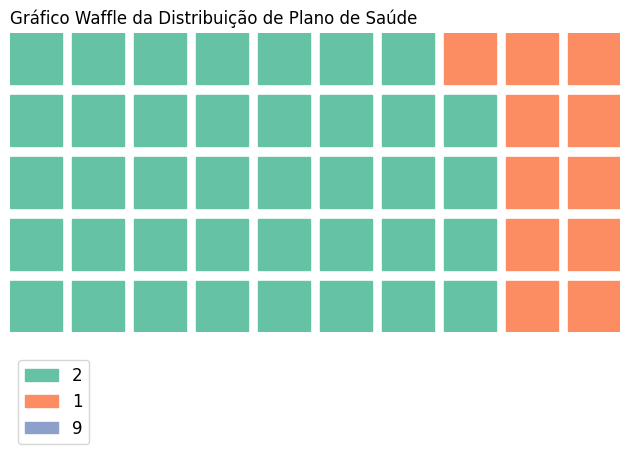

In [36]:
fig = go.Figure()
fig.add_trace(go.Pie(labels=df_pnad_plano_saude.index, values=df_pnad_plano_saude.values, hole=.65))
fig.update_layout(title='Segmentação por sexo')
fig.show()

fig = plt.figure(
    FigureClass=Waffle,
    rows=5,
    columns=10,
    values=df_pnad_plano_saude,
    title={'label': 'Gráfico Waffle da Distribuição de Plano de Saúde', 'loc': 'left'},
    labels=df_pnad_plano_saude.index.array,
    legend={'loc': 'lower left', 'bbox_to_anchor': (0, -0.4), 'fontsize': 12},
    plot_anchor='C'
)
plt.show()

## 3.7) Sintomas mais comuns

In [37]:
df_resposta

,id,nome
0,9,Ignorado
1,2,Não
2,3,Não sabe
3,1,Sim


In [38]:
colunas_sintomas = ['sintoma_febre_b0011',
       'sintoma_tosse_b0012', 'sintoma_dor_garganta_b0013',
       'sintoma_dificuldade_respiracao_b0014', 'sintoma_dor_cabeca_b0015',
       'sintoma_dor_peito_b0016', 'sintoma_nausea_b0017',
       'sintoma_nariz_entupido_b0018', 'sintoma_fadiga_b0019',
       'sintoma_dor_olhos_b00110', 'sintoma_perda_olfato_b00111',
       'sintoma_dor_muscular_b00112', 'sintoma_diarreia_b00113']
df_pnad_sintomas = df_pnad[colunas_sintomas]

In [39]:
df_pnad_sintomas.head()

,sintoma_febre_b0011,sintoma_tosse_b0012,sintoma_dor_garganta_b0013,sintoma_dificuldade_respiracao_b0014,sintoma_dor_cabeca_b0015,sintoma_dor_peito_b0016,sintoma_nausea_b0017,sintoma_nariz_entupido_b0018,sintoma_fadiga_b0019,sintoma_dor_olhos_b00110,sintoma_perda_olfato_b00111,sintoma_dor_muscular_b00112,sintoma_diarreia_b00113
0,2,2,2,2,2,2,2,2,2,2,2,2,2
1,2,2,2,2,2,2,2,2,2,2,2,2,2
2,2,2,2,2,2,2,2,2,2,2,2,2,2
3,2,2,2,2,2,2,2,2,2,2,2,2,2
4,2,2,2,2,2,2,2,2,2,2,2,2,2


In [40]:
# soma o total de casos por sintoma
total_por_sintoma = df_pnad_sintomas.apply(lambda col: (col == 1).sum())
total_por_sintoma

sintoma_febre_b0011                      9020
sintoma_tosse_b0012                     15373
sintoma_dor_garganta_b0013              12557
sintoma_dificuldade_respiracao_b0014     4799
sintoma_dor_cabeca_b0015                18960
sintoma_dor_peito_b0016                  3448
sintoma_nausea_b0017                     3958
sintoma_nariz_entupido_b0018            16140
sintoma_fadiga_b0019                     8208
sintoma_dor_olhos_b00110                 3671
sintoma_perda_olfato_b00111              4413
sintoma_dor_muscular_b00112             10883
sintoma_diarreia_b00113                  4301
dtype: int64

In [41]:
# Criar o gráfico de barras horizontais
fig = go.Figure(go.Bar(
            x=total_por_sintoma.values,
            y=total_por_sintoma.index,
            orientation='h'))

# Atualizar o layout
fig.update_layout(title='Distribuição por tipo de sintoma',
                  xaxis_title='Número de Indivíduos',
                  yaxis_title='Faixas Etárias')

# Mostrar o gráfico
fig.show()

In [42]:
df_pnad_sintomas.columns

Index(['sintoma_febre_b0011', 'sintoma_tosse_b0012',
       'sintoma_dor_garganta_b0013', 'sintoma_dificuldade_respiracao_b0014',
       'sintoma_dor_cabeca_b0015', 'sintoma_dor_peito_b0016',
       'sintoma_nausea_b0017', 'sintoma_nariz_entupido_b0018',
       'sintoma_fadiga_b0019', 'sintoma_dor_olhos_b00110',
       'sintoma_perda_olfato_b00111', 'sintoma_dor_muscular_b00112',
       'sintoma_diarreia_b00113'],
      dtype='object')

In [43]:
# Contar exclusivamente os registros que possuem o valor 1 em cada coluna
total_por_sintoma = df_pnad_sintomas.apply(lambda col: (col == 1).sum())

# Criar um DataFrame com os totais de cada sintoma
df_total_sintomas = pd.DataFrame({'sintoma': total_por_sintoma.index, 'total': total_por_sintoma.values})

# Criar um dicionário para mapear sintomas para categorias principais
categorias = {
    'sintoma_febre_b0011': 'Respiratório',
    'sintoma_tosse_b0012': 'Respiratório',
    'sintoma_dor_garganta_b0013': 'Respiratório',
    'sintoma_dificuldade_respiracao_b0014': 'Respiratório',
    'sintoma_dor_cabeca_b0015': 'Geral',
    'sintoma_dor_peito_b0016': 'Geral',
    'sintoma_nausea_b0017': 'Geral',
    'sintoma_nariz_entupido_b0018': 'Respiratório',
    'sintoma_fadiga_b0019': 'Geral',
    'sintoma_dor_olhos_b00110': 'Geral',
    'sintoma_perda_olfato_b00111': 'Respiratório',
    'sintoma_dor_muscular_b00112': 'Geral',
    'sintoma_diarreia_b00113': 'Gastrointestinal'
}

# Adicionar a coluna de categoria principal ao DataFrame de totais
df_total_sintomas['categoria'] = df_total_sintomas['sintoma'].map(categorias)
total_por_categoria = df_total_sintomas.groupby('categoria')['total'].sum()
df_total_sintomas['porcentagem'] = df_total_sintomas.apply(lambda x: (x['total'] / total_por_categoria[x['categoria']]) * 100, axis=1)

df_total_sintomas

,sintoma,total,categoria,porcentagem
0,sintoma_febre_b0011,9020,Respiratório,14.477866
1,sintoma_tosse_b0012,15373,Respiratório,24.674970
2,sintoma_dor_garganta_b0013,12557,Respiratório,20.155051
3,sintoma_dificuldade_respiracao_b0014,4799,Respiratório,7.702802
4,sintoma_dor_cabeca_b0015,18960,Geral,38.593063
5,sintoma_dor_peito_b0016,3448,Geral,7.018401
6,sintoma_nausea_b0017,3958,Geral,8.056505
7,sintoma_nariz_entupido_b0018,16140,Respiratório,25.906070
8,sintoma_fadiga_b0019,8208,Geral,16.707377
9,sintoma_dor_olhos_b00110,3671,Geral,7.472317


In [44]:
df_total_sintomas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   sintoma      13 non-null     object 
 1   total        13 non-null     int64  
 2   categoria    13 non-null     object 
 3   porcentagem  13 non-null     float64
dtypes: float64(1), int64(1), object(2)
memory usage: 544.0+ bytes


In [45]:
import plotly.express as px

fig = px.treemap(
    df_total_sintomas,
    path=[px.Constant("Todos"), 'categoria', 'sintoma'],
    values='total',
    custom_data=['total', 'porcentagem'],
  )

# Atualizar layout para melhor visualização
fig.update_layout(
    title='Treemap de Sintomas da COVID-19',
    margin=dict(t=50, l=25, r=25, b=25),
)

fig.update_traces(
    hovertemplate='<b>%{label}</b><br>Total: %{customdata[0]}<br>Porcentagem: %{customdata[1]:.2f}%',
    texttemplate='<b>%{label}</b><br>%{customdata[1]:.2f}%',
    hoverlabel=dict(
        font=dict(color='white')
    ),
    textposition='middle center'
)

# Exibir o treemap
fig.show()

## 3.8) Sintoma + resultado positivo

In [49]:
colunas = colunas_sintomas.copy()
colunas.append('resultado_exame_b009b')

df_sintoma_resultado_positivo = df_pnad[colunas]

filtro_qualquer_sintoma_apresentado = (df_sintoma_resultado_positivo.iloc[:, :-1] == 1).any(axis=1)
filtro_covid_confirmado = (df_sintoma_resultado_positivo['resultado_exame_b009b'] == 1)
df_sintoma_resultado_positivo_filtrado = df_sintoma_resultado_positivo[filtro_qualquer_sintoma_apresentado & filtro_covid_confirmado]
df_sintoma_resultado_positivo_filtrado.head()

,sintoma_febre_b0011,sintoma_tosse_b0012,sintoma_dor_garganta_b0013,sintoma_dificuldade_respiracao_b0014,sintoma_dor_cabeca_b0015,sintoma_dor_peito_b0016,sintoma_nausea_b0017,sintoma_nariz_entupido_b0018,sintoma_fadiga_b0019,sintoma_dor_olhos_b00110,sintoma_perda_olfato_b00111,sintoma_dor_muscular_b00112,sintoma_diarreia_b00113,resultado_exame_b009b
176,1,1,2,2,2,2,2,2,2,2,2,2,2,1
3192,1,2,2,2,2,2,2,2,2,2,2,2,2,1
4734,1,1,2,2,2,2,2,2,2,2,2,1,2,1
5455,1,1,1,1,2,2,2,1,1,2,1,1,2,1
6827,1,1,1,2,1,2,2,2,1,1,1,1,2,1


In [ ]:
# TODO: DAR OUTPUT DO GRAFICO

## 3.9) Escolaridade + resultado positivo

In [50]:
df_pnad.columns

Index(['uf', 'capital', 'regiao_metropolitana', 'semana_mes_v1012',
       'mes_v1013', 'situacao_domicilio_v1022', 'tipo_area_v1023',
       'morador_idade_a002', 'morador_sexo_a003', 'morador_raca_a004',
       'morador_escolaridade_a005', 'sintoma_febre_b0011',
       'sintoma_tosse_b0012', 'sintoma_dor_garganta_b0013',
       'sintoma_dificuldade_respiracao_b0014', 'sintoma_dor_cabeca_b0015',
       'sintoma_dor_peito_b0016', 'sintoma_nausea_b0017',
       'sintoma_nariz_entupido_b0018', 'sintoma_fadiga_b0019',
       'sintoma_dor_olhos_b00110', 'sintoma_perda_olfato_b00111',
       'sintoma_dor_muscular_b00112', 'sintoma_diarreia_b00113',
       'compareceu_estabelecimento_saude_b002', 'sedado_entubado_b006',
       'tem_plano_saude_b007', 'resultado_exame_b009b',
       'medida_restricao_contato_b011', 'trabalhou_remoto_c013',
       'recebeu_auxilio_emergencial_d0051'],
      dtype='object')

In [73]:
colunas = ['morador_escolaridade_a005', 'resultado_exame_b009b']

df_escolaridade_covid = df_pnad[df_pnad['resultado_exame_b009b'] == 1]
df_escolaridade_covid = df_escolaridade_covid[colunas].groupby('morador_escolaridade_a005').agg(contagem=('resultado_exame_b009b', 'count'))
df_escolaridade_covid

,contagem
morador_escolaridade_a005,
1,502
2,2279
3,827
4,1021
5,4269
6,1452
7,3133
8,967


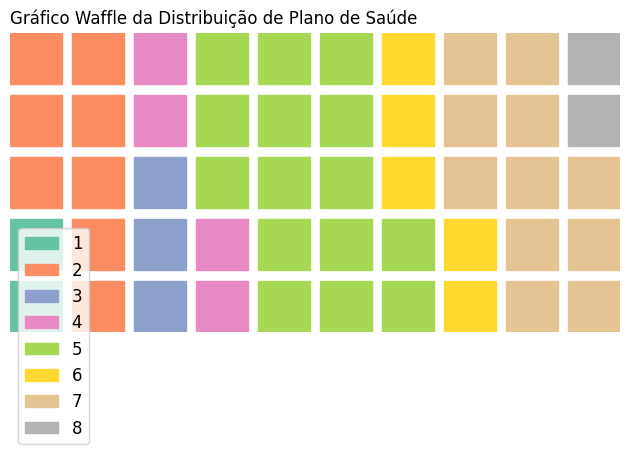

In [74]:
# donut
fig = go.Figure()
fig.add_trace(
      go.Pie(
          labels=df_escolaridade_covid.index,
          values=df_escolaridade_covid['contagem'],
          hole=.65
      )
    )
fig.update_layout(title='COVID19 confirmada X Plano de saúde')
fig.show()

# waffle
fig = plt.figure(
    FigureClass=Waffle,
    rows=5,
    columns=10,
    values=df_escolaridade_covid['contagem'],
    title={'label': 'Gráfico Waffle da Distribuição de Plano de Saúde', 'loc': 'left'},
    labels=df_escolaridade_covid.index.array,
    legend={'loc': 'lower left', 'bbox_to_anchor': (0, -0.4), 'fontsize': 12},
    plot_anchor='C'
)
plt.show()

## 3.10) Plano de saúde + resultado positivo

In [72]:
colunas = ['tem_plano_saude_b007', 'resultado_exame_b009b']

df_plano_saude_covid = df_pnad[(df_pnad['resultado_exame_b009b'] == 1)]
df_plano_saude_covid = df_plano_saude_covid[colunas].groupby('tem_plano_saude_b007').agg(contagem=('resultado_exame_b009b', 'count'))
df_plano_saude_covid

,contagem
tem_plano_saude_b007,
1,6714
2,7722
9,14


TODO: encapsular numa função???

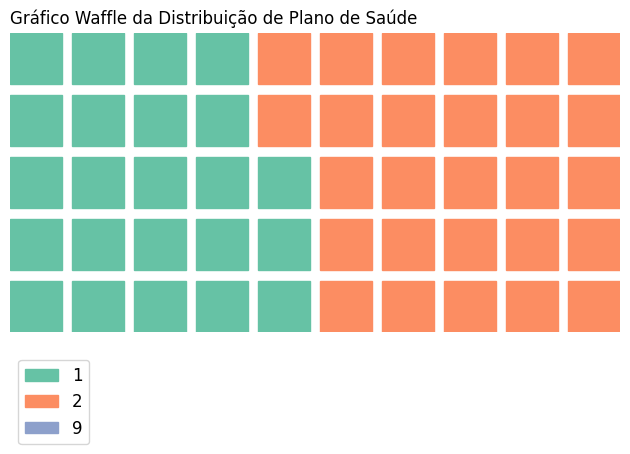

In [71]:
# donut
fig = go.Figure()
fig.add_trace(
      go.Pie(
          labels=df_plano_saude_covid.index,
          values=df_plano_saude_covid['contagem'],
          hole=.65
      )
    )
fig.update_layout(title='COVID19 confirmada X Plano de saúde')
fig.show()

# waffle
fig = plt.figure(
    FigureClass=Waffle,
    rows=5,
    columns=10,
    values=df_plano_saude_covid['contagem'],
    title={'label': 'Gráfico Waffle da Distribuição de Plano de Saúde', 'loc': 'left'},
    labels=df_plano_saude_covid.index.array,
    legend={'loc': 'lower left', 'bbox_to_anchor': (0, -0.4), 'fontsize': 12},
    plot_anchor='C'
)
plt.show()

# 4) Machine Learning

In [95]:
matriz_correlacao = df_pnad.corr()

# Criar o Heatmap usando Plotly
fig = go.Figure(data=go.Heatmap(z=matriz_correlacao.values,
                                 x=matriz_correlacao.columns,
                                 y=matriz_correlacao.columns,
                                 colorbar=dict(title='Correlação'),
                                 colorscale='Viridis',
                                 xgap=1,
                                 ygap=1))

# Adicionar título ao gráfico
fig.update_layout(title='Matriz de Correlação')
fig.update_layout(xaxis_side="top")

# Exibir o gráfico
fig.show()

In [ ]:
# TALVEZ RODAR VIA DATAPROC? (EXPLICAR NO TRABALHO SOBRE ELE)
#https://cloud.google.com/dataproc/docs/tutorials/bigquery-sparkml?hl=pt-br

# calcular metodo elbow
# usar xgboost
# usar algoritmo que se sair melhor
# rodar kmean via google bigquery
# apresentar ambos resultados com os graficos e centroides
# quais conclusoes tiro do resultado?